Epoch 1/3
✓ Done
Epoch 2/3
✓ Done
Epoch 3/3
✓ Done


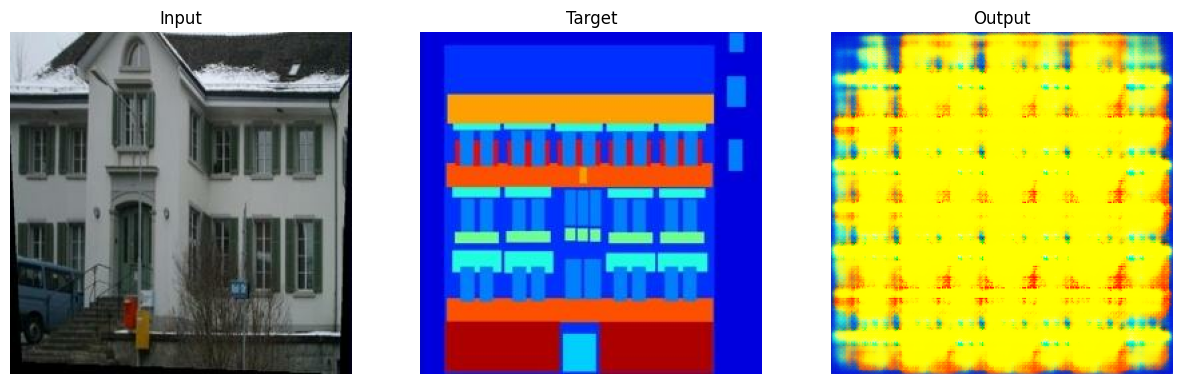

In [2]:
# STEP 1: Install dependencies
!pip install -q tensorflow tensorflow-datasets matplotlib

# STEP 2: Import libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# STEP 3: Load dataset
dataset, info = tfds.load('cycle_gan/facades', with_info=True)
train_dataset = tf.data.Dataset.zip((dataset['trainA'], dataset['trainB']))
test_dataset = tf.data.Dataset.zip((dataset['testA'], dataset['testB']))

# STEP 4: Normalize
def normalize(input_dict, target_dict):
    input_image = tf.cast(input_dict['image'], tf.float32) / 127.5 - 1
    target_image = tf.cast(target_dict['image'], tf.float32) / 127.5 - 1
    return input_image, target_image

train_dataset = train_dataset.map(normalize).shuffle(100).batch(1)
test_dataset = test_dataset.map(normalize).batch(1)

# STEP 5: Downsample and Upsample blocks
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

# STEP 6: Build Generator
def build_generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

generator = build_generator()

# STEP 7: Build Discriminator
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3])
    tar = tf.keras.layers.Input(shape=[256, 256, 3])
    x = tf.keras.layers.concatenate([inp, tar])
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = build_discriminator()

# STEP 8: Losses and Optimizers
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + (100 * l1_loss)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# STEP 9: Training Step
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

# STEP 10: Train for 3 Epochs
EPOCHS = 3
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for input_image, target in train_dataset:
        train_step(input_image, target)
    print("✓ Done")

# STEP 11: Show output
for example_input, example_target in test_dataset.take(1):
    prediction = generator(example_input, training=False)
    plt.figure(figsize=(15, 5))
    for i, img in enumerate([example_input[0], example_target[0], prediction[0]]):
        plt.subplot(1, 3, i+1)
        plt.imshow((img + 1) / 2)
        plt.title(["Input", "Target", "Output"][i])
        plt.axis('off')
    plt.show()


In [3]:
from PIL import Image
import numpy as np
from google.colab import files

# Generate image from test set
for example_input, example_target in test_dataset.take(1):
    prediction = generator(example_input, training=False)

    # Convert from [-1, 1] to [0, 255]
    output_image = (prediction[0].numpy() + 1) * 127.5
    output_image = output_image.astype(np.uint8)

    # Save as PNG
    image = Image.fromarray(output_image)
    image.save("generated_output.png")

    # Download
    files.download("generated_output.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>